# MMM Toy Data Set

* Create a toy data set to explore relationships in Robyn
* Data set should include pre-Robyn window period to avoid cold start and take advantage of how Robyn uses data outside the window to estimate carryover marketing effects going into the first window day.

In [1]:
import os
import sys
import pandas as pd
import numpy as np

In [2]:
np.random.seed(43)

bookings_columns = ['bookings_noiseless', 'bookings_noisy', 'bookings_noisy_context']

#
# data set has no lag effect from media at all here
#
for stderr in [600000]:
    print(f'Creating data set with stderr {stderr}')
    df = pd.DataFrame({'date':pd.date_range(start='2015-01-01', end='2021-12-31')})

    # marketing effort
    #
    # random tv marketing from 0 to 10000 each period
    df['tv'] = np.random.randint(0, 10000, size=len(df))
    
    # context variables for testing 
    df['context_0_center'] = np.random.normal( size=len(df))
    df['context_100_center'] = 100 + df.context_0_center
    
    
    fixed_bookings = 10000000
    tv_scale = 200
    context_scale = 800000
    df['tv_contribution'] = df.tv * tv_scale
    df['bookings_noiseless'] = fixed_bookings + df.tv_contribution
    df['bookings_noisy'] = df.bookings_noiseless + np.random.normal(loc=0, scale=stderr, size=len(df)) 
    
    # we use this whether predicting with context_0_center or context_100_center.  Those are two different forms of describing the same context
    df['bookings_noisy_context'] = df.bookings_noisy + df.context_0_center * context_scale
        
    for i in bookings_columns:
        print(f'Checking {i} for negative values')
        assert len(df[df[i]<0]) == 0, f'{i} has negative values which is not permitted'
    
    df.to_csv(os.path.join('data', f'robyn_toy_data_1paidvar_{stderr}err.csv'))


Creating data set with stderr 600000
Checking bookings_noiseless for negative values
Checking bookings_noisy for negative values
Checking bookings_noisy_context for negative values


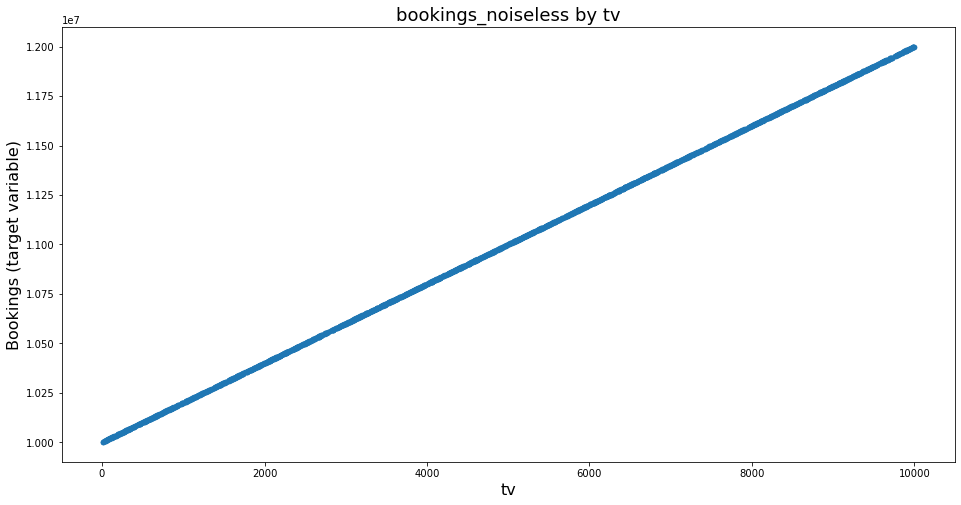

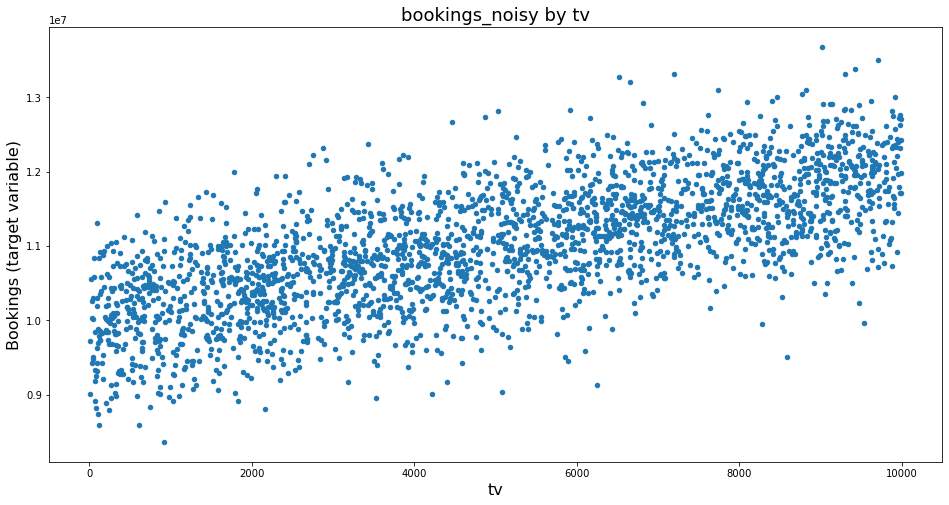

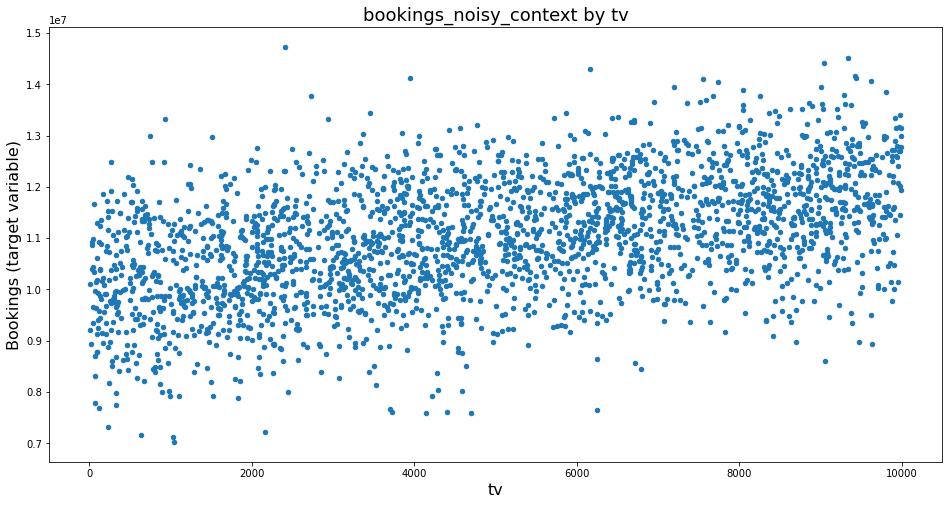

In [3]:
import matplotlib.pyplot as plt

for i in bookings_columns:
    for ivar in ['tv']:
        ax = df.plot.scatter(y=i, x=ivar, figsize=(16,8))
        ax.set_title(f'{i} by {ivar}', fontsize=18)
        ax.set_ylabel('Bookings (target variable)', fontsize=16)
        ax.set_xlabel(ivar, fontsize=16)
        plt.show()

In [4]:
for i in bookings_columns:
    print(f'{i}: mean {df[i].mean():.0f} and stddev {df[i].std():.0f}')

bookings_noiseless: mean 10994678 and stddev 571638
bookings_noisy: mean 10999951 and stddev 829212
bookings_noisy_context: mean 11005741 and stddev 1158994


In [5]:
# entire mean, not the window
df.tv.mean()

4973.388345717638

In [6]:
# entire period, not the window
df.tv.mean()*tv_scale

994677.6691435276

## Checking the correct answer in Robyn for 2021 Window

In [7]:
df2021 = df[df['date'] >= pd.to_datetime('2021/01/01', format='%Y/%m/%d')]
len(df2021)

365

In [8]:
df2021.tv.mean()

4961.465753424657

In [9]:
df2021.tv.sum()*tv_scale

362187000

In [10]:
df2021.bookings_noiseless.sum()

4012187000

In [11]:
df2021.bookings_noisy.sum()

4008432475.7273545

In [12]:
df2021.tv_contribution.sum()

362187000